In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [7]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)

In [8]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        actions = [[env.find_words_matching_current_history]]
        actions.append([env.find_words_matching_current_history, env.find_words_with_highest_new_letter_freq_score])
        actions.append([env.find_words_matching_current_history, env.find_words_with_most_new_letters])
        actions.append([env.find_words_matching_current_history, env.find_words_with_most_new_letters, env.find_words_with_highest_new_letter_freq_score])
        actions.append([env.find_words_with_most_new_letters, env.find_words_with_highest_new_letter_freq_score])
        actions.append([env.find_words_with_most_new_letters])
        actions.append([env.find_words_with_highest_new_letter_freq_score])
        
        self.actions = actions.copy()
        for a in actions:
                self.actions.append([env.find_target_words] + a)
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [9]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [10]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    transitions = memory.sample(batch_size)

    state_batch = torch.stack([tr.state for tr in transitions])
    action_batch = torch.stack([tr.action for tr in transitions])
    reward_batch = torch.tensor([tr.reward for tr in transitions], device=device)
       
    # calculate gradient
    probs = model(state_batch)
    sampler = Categorical(probs)
    print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action_batch)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
    
    pseudo_loss = torch.sum(log_probs * reward_batch) # loss that when differentiated with autograd gives the gradient of J(θ)
    print(f'Glog {(log_probs * reward_batch).shape}')
    print(f'pseudo loss {pseudo_loss} {pseudo_loss.__class__}')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()
    
    print(list(model.parameters()))
    
    return pseudo_loss

def optimize_model_single(model, optimizer, state, action, reward):
        
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    print(f'Glog {(log_probs * reward).shape}')
    print(f'pseudo loss {pseudo_loss} {pseudo_loss.__class__}')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [11]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
        
    if training.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)
        
    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action shape {action_idx.__class__} {action.shape} {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for tr in episode_memory:
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    #memory.push(tr[0], tr[1], episode_reward)
                    episode_reward -= tr[2]
                    loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    losses.append(loss)
                
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                #if len(memory) >= training.batch_size \
                #    and steps_done - last_training > training.train_interval:
                #    loss = optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                #    losses.append(loss)
                #    if training.clear_memory: memory.clear()
                #    last_training = steps_done
                
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=300,
    training=TrainConfig(optimizer='adam', lr=0.04)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 3 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 13 slink-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 13
------guess 3 10 macro-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 8 favor-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 7 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.15210629591208413  steps 34  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -8.434326171875 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.383236408233643 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.9940707683563232 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: 

------guess 3 1 macaw-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 4 1 magma-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 5 8 mamma-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 14 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.2846619136474401  steps 68  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -8.457733154296875 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.276220321655273 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.7286193370819092 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.637878656387329 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Cate

------guess 3 1 party-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 21 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3873736058155839  steps 99  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.354763984680176 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.249281883239746 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 22 thing======================
------guess 0 6 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 1 1 sluit-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 5 chynd-------
reward -1 done False action shape <class 'torch.Tensor

------guess 4 9 fever-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 5 9 freer-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 28 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.4908435793924508  steps 136  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.834054470062256 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.692817687988281 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.2127954959869385 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.355160117149353 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
==========

------guess 2 9 lurid-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 36 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5661255185670091  steps 168  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.49042773246765137 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 37 fiend======================
------guess 0 13 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 13
------guess 1 6 cions-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 5 jumpy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 3 9 fiend-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size

------guess 1 0 colts-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 10 lusty-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 45 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.6357810204284766  steps 203  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.5036522150039673 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 46 apron======================
------guess 0 6 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 1 0 coria-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 5 musky-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Siz

------guess 1 0 teiid-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 0 piend-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 3 9 fiend-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 53 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6911810203119801  steps 236  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.677931785583496 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.5422710180282593 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 54 quash======================
------guess 0 5 patsy-------
reward -1 done False action shape <class 'torch.Tens

------guess 1 5 pomes-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 2 9 nomad-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 woman-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 61 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7394602921400244  steps 270  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.172637939453125 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.4315576553344727 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 62 frost======================
------guess 0 10 later-------
reward -1 done False action shape <class 'torch.Ten

------guess 3 9 hyper-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 69 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7790900220406218  steps 303  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.4172444343566895 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.172431707382202 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 70 lumen======================
------guess 0 13 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 13
------guess 1 5 buiks-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 2 10 lumen-------
reward 0 done True action shape <class 'torch.Ten

------guess 1 5 whios-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 2 1 dulse-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 9 pulse-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 78 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.81362602396059  steps 337  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1278232336044312 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.0787155628204346 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 79 junta======================
------guess 0 13 alter-------
reward -1 done False action shape <class 'torch.Tens

------guess 1 0 betid-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 9 neigh-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 weigh-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 88 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8435470573250452  steps 372  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.3445333242416382 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.4001091420650482 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 89 theta======================
------guess 0 0 bulse-------
reward -1 done False action shape <class 'torch.Ten

------guess 1 0 wries-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 9 rhyme-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 9 purge-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 4 9 curve-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 97 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8699712891215741  steps 409  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.750185489654541 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.0238213539123535 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.6219155788421631 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs:

------guess 3 9 unite-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 4 9 untie-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 105 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8902993514844886  steps 443  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -12.1865816116333 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.9448833465576172 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.9099414348602295 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 106 knelt======================
------guess 0 13 later-------
reward -1 done False action shape

------guess 1 1 soare-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 10 saner-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 9 spear-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 4 9 shear-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 5 9 swear-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 9
episode 113 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9074494224896568  steps 477  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.4026676416397095 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -11.672608375549316 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.8806895017623901 <class 'torch.Tensor'>
sampler Categorical(pr

------guess 1 0 clang-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 9 flash-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 3 0 plaza-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 4 0 plaid-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 0
episode 121 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9211336002093251  steps 509  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.424172401428223 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.2447361946105957 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.8386537432670593 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=300,
    training=TrainConfig(optimizer='rmsprop', lr=0.04)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 0 2 forex-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 1 10 stale-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 heist-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 zesty-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 testy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 6 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.1435848225163865  steps 32  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.096320629119873 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.14392349123954773 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.019923800602555275 <class 'torch.Tensor'>
sampler Categorica

------guess 3 10 phone-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 15 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.2774726463579278  steps 66  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.987181743374094e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 16 whole======================
------guess 0 10 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 louse-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 whole-------
reward 0 done True action shape <class

------guess 2 10 merit-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 recut-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 25 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3995044211877341  steps 103  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.351186362328008e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 26 creep======================
------guess 0 10 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 credo-------
reward -1 done False action shape <cl

------guess 0 10 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 stoic-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 snout-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 shout-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 spout-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 34 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.49338300763441045  steps 137  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.508897786261514e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
samp

------guess 0 10 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 aisle-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 angle-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 ample-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 amble-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 43 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5768379176822511  steps 173  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.598306936211884e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampl

------guess 1 10 loser-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 liner-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 liver-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 51 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6394050598269216  steps 205  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.470398198463954e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 52 allow======================
------guess 0 10 alter-------
reward -1 done False action shape <cl

------guess 1 10 stone-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 edict-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 eight-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 60 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6911810203119801  steps 236  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.5300042984308675e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 61 alley======================
------guess 0 10 later-------
reward -1 done False action shape <c

------guess 1 10 renal-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 pearl-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 69 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7407597393541085  steps 271  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.3126869564293884e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 70 trait======================
------guess 0 10 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 roast-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 grant-------
reward -1 done False action shape <class 'torch.Tensor'

------guess 0 10 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 credo-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 cress-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 79 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7823789431347671  steps 306  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.360371763643343e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 80 grout======================
------guess 0 10 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 snort-------
reward -1 done False action shape <class 'torch.Tensor'>

------guess 3 10 cyber-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 cheer-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 87 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8173164759472653  steps 341  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.25993377272971e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 88 meant======================
------guess 0 10 later-------
reward -1 done Fals

------guess 3 10 shore-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 spore-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 5 10 swore-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 97 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8489281911636292  steps 379  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -9.91833585430868e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.576279254957626e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.3841860752327193e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torc

------guess 3 10 thyme-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 104 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8706198100226289  steps 410  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.126065298100002e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 105 dopey======================
------guess 0 10 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 nosey-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 dopey-------
reward 0 done True action shape <cl

------guess 1 10 sonic-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 pushy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 gypsy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 114 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8919325813651707  steps 446  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.2810413762927055e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 115 drape======================
------guess 0 10 alter-------
reward -1 done False action shape 

------guess 0 10 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 scorn-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 chord-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 124 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9110783825406137  steps 485  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.7478119591251016e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 125 lingo======================
------guess 0 10 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 solid-------
reward -1 done False action shape <class 'torch.Tenso

------guess 2 10 house-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 mouse-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 133 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9253541239255645  steps 520  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.698285167454742e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1920930376163597e-07 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 134 sprig======================
------guess 0 10 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 irony-------
reward -1 done False action shape <

------guess 2 10 stung-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 141 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9367082316403592  steps 553  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.968355329358019e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 142 sissy======================
------guess 0 10 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 10 scion-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 squib-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 sissy-------
reward 0 done True action shape <class 'torch.Tensor'>

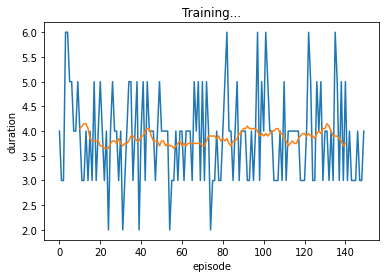

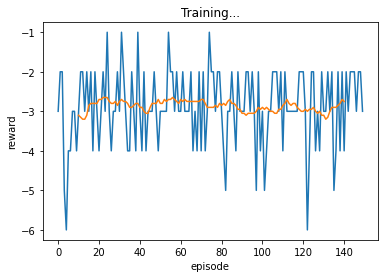

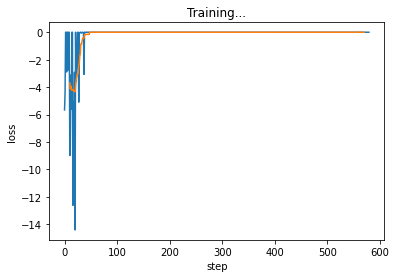

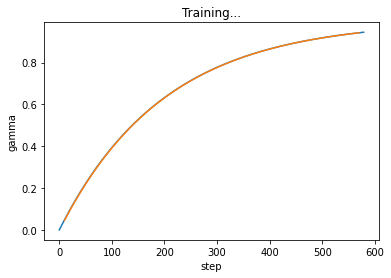

In [14]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(lr=0.99),
    seed=0
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 0 4 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 1 3 aisle-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 7 agile-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 3 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.06760618009405173  steps 15  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.460365295410156 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 4 pecan======================
------guess 0 8 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 9 media-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([])

------guess 2 1 intro-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 13 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.21337213893344653  steps 49  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.9900789856910706 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 14 suave======================
------guess 0 1 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 7 suave-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 14 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.22119921692859512  steps 51  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor

Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 23 naive======================
------guess 0 10 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 1 3 saine-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 3 naive-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 3
episode 23 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.3494909052766835  steps 87  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.359250783920288 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 24 genre======================
------guess 0 3 orate-------
reward -1 done False action shape <class 'torch.

------guess 0 3 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 1 3 liane-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 3 chase-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 3 3 cease-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 3
episode 31 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.4539255733602906  steps 122  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.150644540786743 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.7542597055435181 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 32 aroma=

------guess 1 3 uraos-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 3 sulci-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 3 3 plush-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 4 3 flush-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 3
episode 41 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5506710358827784  steps 161  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -9.391637802124023 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.08722223341464996 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.10147248208522797 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(prob

------guess 1 2 porny-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 2 dower-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 2 loser-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 4 2 hover-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 5 2 boxer-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 48 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.622807646436843  steps 196  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.2200215756893158 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.06429136544466019 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.006202130578458309 <class 'torch.Tensor'>
sampler Categorical(pro

------guess 2 2 flawy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 2 leafy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 56 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.680180978183696  steps 229  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.08431996405124664 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.018516872078180313 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 57 flora======================
------guess 0 2 gulas-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 1 2 flawy-------
reward -1 done False action shape <class 'torch.T

------guess 0 2 shorl-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 1 2 mined-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 2 wanky-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 2 punga-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 4 2 junta-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 65 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7328646980341497  steps 265  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.6884645819664001 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.19997638463974 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.015201188623905182 <class 'torch.Tensor'>
sampler Categorical(probs:

------guess 1 2 loves-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 2 enoki-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 2 epoxy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 72 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7734976593235312  steps 298  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.211692810058594 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.03142954409122467 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 73 exert======================
------guess 0 5 meals-------
reward -1 done False action shape <class 'torch.Ten

------guess 0 2 strae-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 1 2 divot-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 2 width-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 80 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8117529343612532  steps 335  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.40777453780174255 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 81 would======================
------guess 0 2 hosel-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 1 2 loric-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size

------guess 2 2 dangs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 3 2 dight-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 4 2 digit-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 2
episode 88 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8411825738930794  steps 369  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.198612213134766 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.8412508964538574 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.1855526715517044 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================

------guess 2 10 decoy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 epoxy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 96 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8639863458331508  steps 400  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.7070217728614807 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0007712238002568483 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 97 finer======================
------guess 0 2 filed-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 1 10 finer-------
reward 0 done True action shape <class 'tor

------guess 1 10 steal-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 leant-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 table-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 107 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8891968416376661  steps 441  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.1833791732788086 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0011505543952807784 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 108 caper======================
------guess 0 8 alter-------
reward -1 done False action shape <class

------guess 0 8 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 snore-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 grope-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 drove-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 117 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9083703161224952  steps 479  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.2640276253223419 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0008707856759428978 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episod

------guess 0 8 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 tonal-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 gloat-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 bloat-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 127 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9249799599146731  steps 519  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.38876962661743164 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0009827673202380538 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episo

------guess 3 10 decry-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 merry-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 136 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9373379952578469  steps 555  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.7896556854248047 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0019948892295360565 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.004639762919396162 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 137 small======================
------guess 0 4 oater-------
reward -1 done False ac

------guess 2 10 melon-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 cello-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 146 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9476602940515676  steps 591  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.1209452152252197 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.001053709420375526 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 147 wrest======================
------guess 0 8 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 crest-------
reward -1 done False action shape <class '

------guess 0 4 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 1 10 saint-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 latch-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 tacky-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 155 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9558428315803071  steps 625  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.0394315719604492 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0011750208213925362 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episod

------guess 1 10 spiel-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 kneel-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 excel-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 bevel-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 163 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9627461506037842  steps 659  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.580698251724243 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0004376651777420193 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.6226387490169145e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Ca

------guess 0 1 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 10 lyric-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 spurn-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 drunk-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 171 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9682543636219321  steps 691  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -9.198807716369629 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.837221290974412e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode

------guess 2 10 mason-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 bacon-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 canon-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 179 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9729481531336496  steps 723  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.3075825273990631 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.173750105313957e-05 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.5497220147153712e-06 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
==========

------guess 0 4 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 1 10 solid-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 young-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 comfy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 hobby-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 5 10 woozy-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 188 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9774043981488781  steps 759  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.27529239654541 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0013482458889484406 <class 'torch.Tensor'>
sampler Categorical(probs: tor

------guess 3 10 seize-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 196 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9806487836303224  steps 790  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.21711201965808868 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.00034397796844132245 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 197 array======================
------guess 0 8 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 arson-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 array-------
reward 0 done True action shape <class 

------guess 2 10 cruel-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 repel-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 4 10 rebel-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 207 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9840771484954883  steps 829  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.4378916621208191 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0013553919270634651 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.00870019942522049 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=============

------guess 2 10 shady-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 shaky-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 217 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9867001164575563  steps 865  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.2972796857357025 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.000725353485904634 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 218 flack======================
------guess 0 8 later-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 snail-------
reward -1 done False action shape <class '

------guess 1 10 scale-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 leach-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 226 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9888353193848828  steps 900  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.11246809363365173 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 227 opera======================
------guess 0 8 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 opera-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 227 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9889464098131406  steps 90

------guess 0 8 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 10 scale-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 10 laden-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 delay-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 237 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9907672653877684  steps 938  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.3899969160556793 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0021032739896327257 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episod

------guess 0 5 itchy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 1 10 early-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 5 numbs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 5
------guess 3 10 every-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 246 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9922495161088634  steps 973  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.43623071908950806 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.03796897828578949 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 2

------guess 2 10 filth-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 3 10 fifty-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 10
episode 254 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9934284135050704  steps 1006  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.3388333320617676 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.07720460742712021 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 255 kneel======================
------guess 0 6 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 1 10 spiel-------
reward -1 done False action shape <class '

------guess 1 6 linos-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 6 duchy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 embog-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 wakfs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 vezir-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 262 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9945926708735591  steps 1045  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.569171905517578 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.03403078392148018 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.00039913924410939217 <class 'torch.Tensor'>
sampler Categorical

------guess 2 6 munch-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 gawky-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 fable-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 avize-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 268 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9954834190573874  steps 1081  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.695065975189209 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.06387224048376083 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.0005989076453261077 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.96047357248608e-06 <class 'torch.Tensor'>
s

------guess 2 6 dumpy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 bhang-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 wakfs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 vizir-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 274 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9962274344812078  steps 1117  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -21.658451080322266 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.010308663360774517 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.00030221077031455934 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.152558509915252e-07 <class 'torch.Tensor

------guess 0 4 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 1 6 lysin-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 6 chump-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 debug-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 wakfs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 cezve-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 280 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9968488884015556  steps 1153  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.3100612461566925 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.015089565888047218 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size(

------guess 0 4 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 1 6 lysin-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 6 chump-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 begad-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 wakfs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 vizir-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 286 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9973679703489868  steps 1189  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.5775551795959473 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.017387455329298973 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size(

------guess 0 4 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 4
------guess 1 6 lysin-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 6 chump-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 budge-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 wakfs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 vozhd-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 292 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9978015440369574  steps 1225  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.978696346282959 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.014417373575270176 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([

------guess 0 6 oater-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 1 6 lysin-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 2 6 chump-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 3 6 badge-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 4 6 wakfs-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 6
------guess 5 6 vizir-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 6
episode 298 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9981636952229711  steps 1261  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.46334144473075867 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.004362577106803656 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size

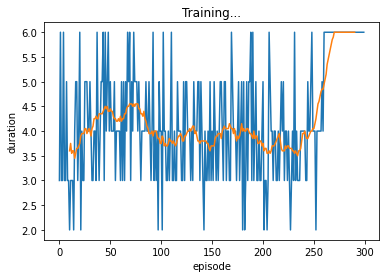

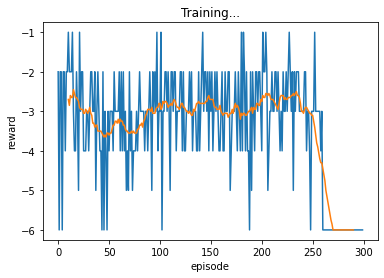

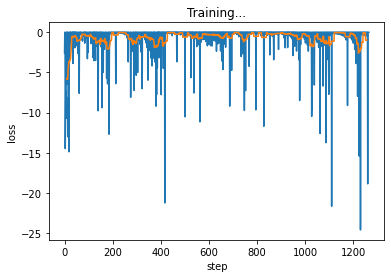

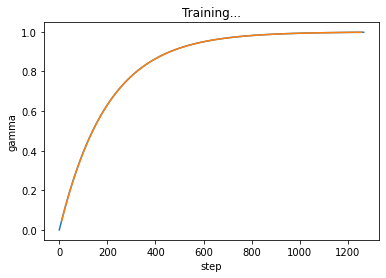

In [15]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=300,
    training=TrainConfig(optimizer='rmsprop', clear_memory=True, lr=0.015),
    seed=0
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 9 vouch-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 9
------guess 2 13 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 13
------guess 3 13 skimp-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 13
------guess 4 13 brief-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 13
------guess 5 13 waltz-------
reward -1 done True action shape <class 'torch.Tensor'> torch.Size([]) 13
episode 4 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.09516258196404048  steps 21  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -11.421919822692871 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -11.873808860778809 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.297501564025879 <class 'torch.Tensor'>
sampler Categorical

------guess 1 10 lyric-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 10
------guess 2 3 grins-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 3 3 shiur-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 4 3 smirk-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 3
episode 12 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.24042787677503152  steps 56  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.7542641162872314 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.56504487991333 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.0070644617080688 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs

------guess 0 11 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 1 3 oints-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 3 couth-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 3 3 pouty-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 3
episode 22 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3934693402873666  steps 101  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.084855079650879 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.2787289619445801 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 23 gidd

------guess 2 3 cains-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 3 11 humid-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 4 7 guava-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 7
episode 29 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.48829142221345756  steps 135  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -6.0622711181640625 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.1550395488739014 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.7646899223327637 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=====================

------guess 4 1 wiser-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 36 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5704426417892609  steps 170  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -7.660407543182373 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.4101929664611816 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.1704039573669434 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 37 berth======================
------guess 0 11 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 1 3 resto-------
reward -1 done False action shape

------guess 2 1 daunt-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 1 tangy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 44 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6357810204284766  steps 203  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.6254891157150269 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.4561880826950073 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 45 broth======================
------guess 0 1 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 7 broth-------
reward 0 done True action shape <class 'torch.Tenso

------guess 2 8 hinge-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 1 pique-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 52 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6911810203119801  steps 236  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.150947570800781 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.7548699975013733 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 53 trait======================
------guess 0 1 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 9 train-------
reward -1 done False action shape <class 'torch.Tens

------guess 0 8 alter-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 1 8 store-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 2 8 route-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 3 8 forte-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 62 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7433392230464442  steps 273  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.772330641746521 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.43837323784828186 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 63 favor

------guess 2 1 eying-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 1 deign-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 4 8 feign-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 70 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.783464332683993  steps 307  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.2401421070098877 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.965215682983398 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.12465709447860718 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================

------guess 3 1 depth-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 77 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8154804760070107  steps 339  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.2081971168518066 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -4.728171348571777 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 78 happy======================
------guess 0 1 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 8 inlay-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 2 1 saucy-------
reward -1 done False action shape <class 'torch.Tens

------guess 3 1 rerun-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 1
episode 85 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8435470573250452  steps 372  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.5761349201202393 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.4586237668991089 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 86 daunt======================
------guess 0 3 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 1 3 alist-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 3
------guess 2 1 daunt-------
reward 0 done True action shape <class 'torch.Tenso

------guess 1 11 sonic-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 2 3 clang-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 3
episode 96 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8738142182949612  steps 415  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.4084570407867432 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 97 reign======================
------guess 0 1 orate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 8 liner-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 8
------guess 2 11 pushy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Si

------guess 2 8 count-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 104 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8935414956207473  steps 449  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.590948224067688 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 105 crick======================
------guess 0 1 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 1 nirls-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 2 1 chiru-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 1 crimp-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size

------guess 2 1 trone-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 3 8 trope-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 112 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9101847054277523  steps 483  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.5606753826141357 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.7234166860580444 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 113 skunk======================
------guess 0 1 roate-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 1
------guess 1 11 sling-------
reward -1 done False action shape <class 'torch.

------guess 2 8 khaki-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 120 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9230808185581655  steps 514  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -2.022357225418091 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 121 loser======================
------guess 0 0 sycee-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 1 8 loser-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 8
episode 121 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9238461772013897  steps 516  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tens

------guess 1 2 ungot-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 2
------guess 2 11 spicy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 3 0 shist-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 4 0 swift-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 0
episode 131 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9373379952578469  steps 555  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -3.373983383178711 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -13.287506103515625 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.065410137176514 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(prob

------guess 1 0 darcy-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 0 hardy-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 0
episode 138 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9466029618548029  steps 587  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.774475336074829 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
=========================episode 139 angel======================
------guess 0 11 alert-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 11
------guess 1 0 aisle-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 2 0 angel-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size

------guess 4 0 aland-------
reward -1 done False action shape <class 'torch.Tensor'> torch.Size([]) 0
------guess 5 0 bland-------
reward 0 done True action shape <class 'torch.Tensor'> torch.Size([]) 0
episode 146 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9553990446597255  steps 623  memory 0
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -5.398751735687256 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.7327102422714233 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -1.72308349609375 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss -0.131657674908638 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
sampler Categorical(probs: torch.Size([14]))
Glog torch.Size([])
pseudo loss 0.0 <class 'torch.Tensor'>
==========

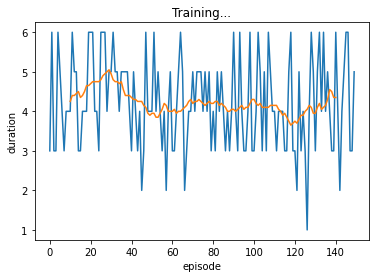

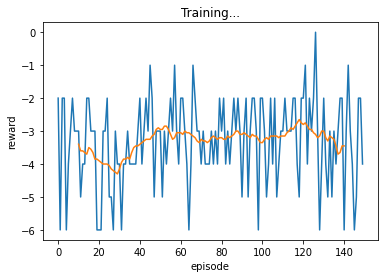

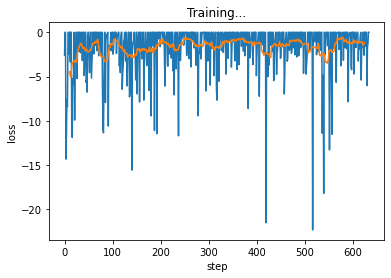

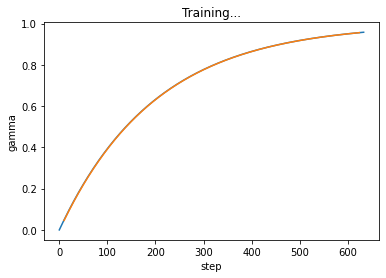

In [16]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=150,
    training=TrainConfig(optimizer='rmsprop', lr=0.01),
    seed=0
    ))